In [20]:
import praw
import pandas as pd
import datetime
import os
import yfinance as yf  
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt 
from collections import Counter
import re


In [11]:


CLIENT_ID = "GGHl0wMWJEsXASC2ypI1Ag"
CLIENT_SECRET = "xzBdRli8k19OnIF2mfAnjsnNe85bkg"
USER_AGENT = "Telehealth Research"

reddit = praw.Reddit(client_id=CLIENT_ID, 
                     client_secret=CLIENT_SECRET, 
                     user_agent=USER_AGENT)

def fetch_reddit_posts(subreddits, limit=100):
    posts = []
    for subreddit in subreddits:
        for post in reddit.subreddit(subreddit).hot(limit=limit):
            posts.append({
                "title": post.title,
                "text": post.selftext,
                "author": str(post.author),
                "upvotes": post.score,
                "date": datetime.datetime.fromtimestamp(post.created_utc).strftime('%Y-%m-%d'),
                "subreddit": subreddit
            })
    return posts

def save_to_csv(data, filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    pd.DataFrame(data).to_csv(filename, index=False)

subreddits = ["Telemedicine", "AskDocs"]
output_file = "datasets/raw/reddit_posts.csv"

data = fetch_reddit_posts(subreddits)
save_to_csv(data, output_file)


In [12]:
def fetch_yfinance_data(tickers, start_date="2022-01-01", end_date="2024-01-01"):
    all_data = {ticker: yf.Ticker(ticker).history(start=start_date, end=end_date)['Close'] for ticker in tickers}
    return pd.DataFrame(all_data)

def save_stock_data(data, filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    data.to_csv(filename)

healthcare_tickers = ["PFE", "JNJ", "MRNA", "UNH", "TDOC", "XLV", "IYH", "VHT"]
output_file = "datasets/raw/healthcare_stock_data.csv"

stock_data = fetch_yfinance_data(healthcare_tickers)
save_stock_data(stock_data, output_file)

In [13]:

url = "https://covid19.who.int/table"
response = requests.get(url)

if response.status_code == 200:
    soup = BeautifulSoup(response.text, "html.parser")
    table = soup.find("table")
    rows = table.find_all("tr")
    
    data = [[col.text.strip() for col in row.find_all("td")] for row in rows]
    
    df = pd.DataFrame(data)
    output_folder = "Datasets/Raw"
    os.makedirs(output_folder, exist_ok=True)
    
    df.to_csv(os.path.join(output_folder, "who_covid_data.csv"), index=False)


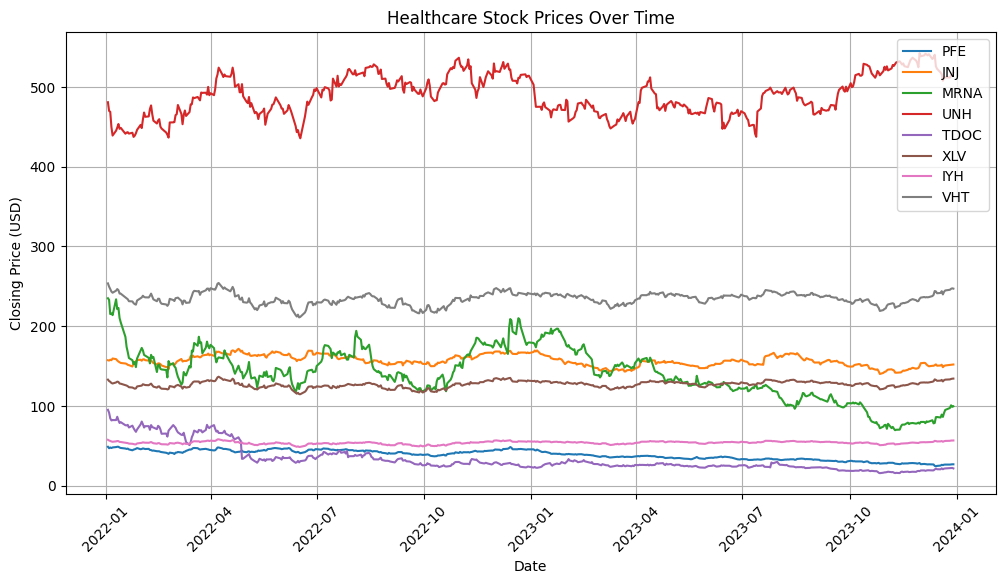

In [ ]:
file_path = "datasets/raw/healthcare_stock_data.csv"
stock_data = pd.read_csv(file_path, index_col=0, parse_dates=True)

plt.figure(figsize=(12, 6))
for column in stock_data.columns:
    plt.plot(stock_data.index, stock_data[column], label=column)

plt.title("Healthcare Stock Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.show()


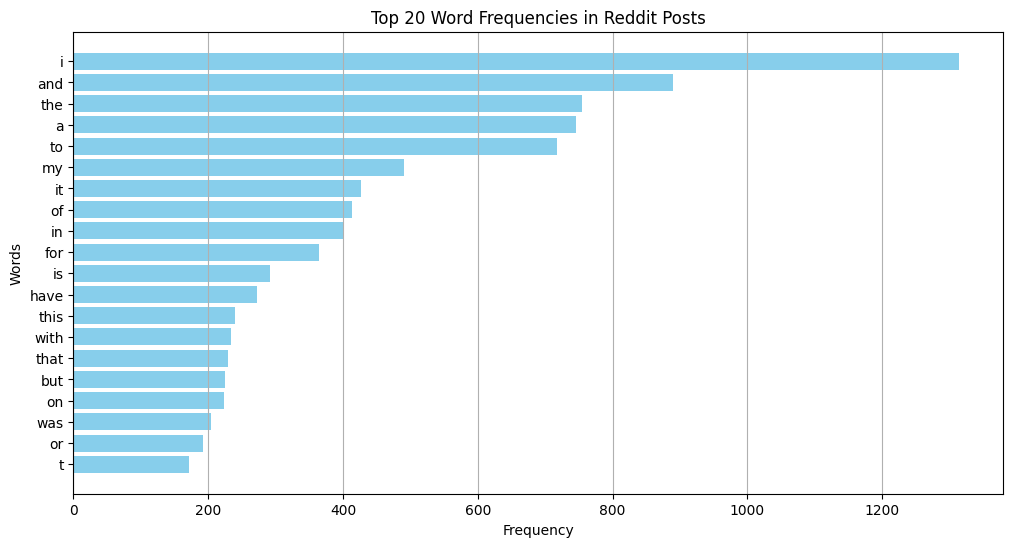

In [21]:



file_path = "datasets/raw/reddit_posts.csv"
df = pd.read_csv(file_path)


text_data = " ".join(df["title"].astype(str) + " " + df["text"].astype(str))


words = re.findall(r'\b\w+\b', text_data.lower())  


word_counts = Counter(words)
common_words = word_counts.most_common(20)  


word_df = pd.DataFrame(common_words, columns=["Word", "Frequency"])


plt.figure(figsize=(12, 6))
plt.barh(word_df["Word"], word_df["Frequency"], color="skyblue")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top 20 Word Frequencies in Reddit Posts")
plt.gca().invert_yaxis()  
plt.grid(axis="x")


plt.show()
